# Hourly Weather Model Training

This notebook trains a Random Forest model on **hourly weather data** from Semarang (2010-2025).
Unlike the daily model, this trains directly on hour-by-hour data for more accurate hourly predictions.

**Key Difference**: Features include `hour` of day in addition to `day`, `month`, `year`.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Ensure plots are displayed inline
%matplotlib inline

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load Hourly Data

In [2]:
csv_path = 'D://laragon//www//weather-iot//examples//data_collections//semarang_weather_2000_2025.csv'
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head(10)

Dataset shape: (227112, 6)
Columns: ['time', 'temperature', 'humidity', 'pressure', 'rain', 'wind_speed']


,time,temperature,humidity,pressure,rain,wind_speed
0,2000-01-01T00:00,23.8,95,1008.1,0.0,4.9
1,2000-01-01T01:00,23.5,95,1007.6,0.0,4.8
2,2000-01-01T02:00,23.7,94,1007.1,0.0,4.0
3,2000-01-01T03:00,23.4,94,1006.7,0.0,5.1
4,2000-01-01T04:00,23.3,94,1006.7,0.0,4.0
5,2000-01-01T05:00,23.1,94,1006.5,0.0,2.9
6,2000-01-01T06:00,23.2,95,1007.3,0.0,2.6
7,2000-01-01T07:00,25.2,89,1008.3,0.0,2.2
8,2000-01-01T08:00,26.1,85,1008.6,0.0,4.9
9,2000-01-01T09:00,27.0,82,1008.6,0.0,7.3


In [3]:
# Check data types and missing values
df.info()
print("\nMissing values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227112 entries, 0 to 227111
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         227112 non-null  object 
 1   temperature  227112 non-null  float64
 2   humidity     227112 non-null  int64  
 3   pressure     227112 non-null  float64
 4   rain         227112 non-null  float64
 5   wind_speed   227112 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 10.4+ MB

Missing values:
time           0
temperature    0
humidity       0
pressure       0
rain           0
wind_speed     0
dtype: int64


## 2. Preprocessing Hourly Data

Process hourly data directly without aggregation.

In [4]:
# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

# Extract temporal features
df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df['day_of_week'] = df['time'].dt.dayofweek  # 0=Monday, 6=Sunday

# Drop rows with missing values
df_clean = df.dropna()

print(f"Original data: {len(df)} rows")
print(f"After cleaning: {len(df_clean)} rows")
print(f"Data removed: {len(df) - len(df_clean)} rows ({(len(df)-len(df_clean))/len(df)*100:.2f}%)")

df_clean.head()

Original data: 227112 rows
After cleaning: 227112 rows
Data removed: 0 rows (0.00%)


,time,temperature,humidity,pressure,rain,wind_speed,hour,day,month,year,day_of_week
0,2000-01-01 00:00:00,23.8,95,1008.1,0.0,4.9,0,1,1,2000,5
1,2000-01-01 01:00:00,23.5,95,1007.6,0.0,4.8,1,1,1,2000,5
2,2000-01-01 02:00:00,23.7,94,1007.1,0.0,4.0,2,1,1,2000,5
3,2000-01-01 03:00:00,23.4,94,1006.7,0.0,5.1,3,1,1,2000,5
4,2000-01-01 04:00:00,23.3,94,1006.7,0.0,4.0,4,1,1,2000,5


## 3. Feature Engineering

Input features: `[hour, day, month, year]`  
Target outputs: `[temperature, humidity, pressure, wind_speed, rain]`

In [5]:
# Features (X): temporal information
X = df_clean[['hour', 'day', 'month', 'year']]

# Targets (y): weather parameters
y = df_clean[['temperature', 'humidity', 'pressure', 'wind_speed', 'rain']]

print("Features (X):")
print(f"  Shape: {X.shape}")
print(f"  Columns: {X.columns.tolist()}")
print("\nTargets (y):")
print(f"  Shape: {y.shape}")
print(f"  Columns: {y.columns.tolist()}")

# Display statistics
print("\nTarget Statistics:")
print(y.describe())

Features (X):
  Shape: (227112, 4)
  Columns: ['hour', 'day', 'month', 'year']

Targets (y):
  Shape: (227112, 5)
  Columns: ['temperature', 'humidity', 'pressure', 'wind_speed', 'rain']

Target Statistics:
         temperature       humidity       pressure     wind_speed  \
count  227112.000000  227112.000000  227112.000000  227112.000000   
mean       26.720299      78.721600    1009.820375       6.596575   
std         2.561273      14.657146       1.897965       4.275621   
min        18.100000      17.000000    1001.800000       0.000000   
25%        24.800000      71.000000    1008.500000       3.600000   
50%        26.300000      82.000000    1009.900000       5.600000   
75%        28.300000      90.000000    1011.200000       8.600000   
max        38.000000     100.000000    1016.700000      38.000000   

                rain  
count  227112.000000  
mean        0.219240  
std         0.800987  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%       

## 4. Train-Test Split

Split data: 80% training, 20% testing.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set size: {X_train.shape[0]:,} samples")
print(f"Testing set size: {X_test.shape[0]:,} samples")
print(f"\nTraining period: {len(X_train)/24/365:.1f} years of hourly data")

Training set size: 181,689 samples
Testing set size: 45,423 samples

Training period: 20.7 years of hourly data


## 5. Model Training

Train RandomForestRegressor on hourly data.

In [7]:
print("Training Random Forest model on hourly data...")
print("This may take a few minutes due to large dataset size...\n")

# Train model
rf_model_hourly = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model_hourly.fit(X_train, y_train)

print("\n✓ Model training complete!")

Training Random Forest model on hourly data...
This may take a few minutes due to large dataset size...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s



✓ Model training complete!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.4s finished


## 6. Model Evaluation

In [8]:
# Make predictions on test set
y_pred = rf_model_hourly.predict(X_test)

# Calculate metrics for each target
target_names = ['temperature', 'humidity', 'pressure', 'wind_speed', 'rain']

print("="*90)
print("HOURLY MODEL PERFORMANCE METRICS")
print("="*90)

metrics_summary = []

for i, name in enumerate(target_names):
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    
    metrics_summary.append({
        'Parameter': name.upper(),
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })
    
    print(f"\n{name.upper()}:")
    print(f"  MAE  (Mean Absolute Error):        {mae:.4f}")
    print(f"  RMSE (Root Mean Squared Error):    {rmse:.4f}")
    print(f"  R²   (Coefficient of Determination): {r2:.4f}")

print("\n" + "="*90)

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics_summary)
print("\nSummary Table:")
print(metrics_df.to_string(index=False))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


HOURLY MODEL PERFORMANCE METRICS

TEMPERATURE:
  MAE  (Mean Absolute Error):        0.5245
  RMSE (Root Mean Squared Error):    0.7099
  R²   (Coefficient of Determination): 0.9231

HUMIDITY:
  MAE  (Mean Absolute Error):        3.2453
  RMSE (Root Mean Squared Error):    4.4897
  R²   (Coefficient of Determination): 0.9063

PRESSURE:
  MAE  (Mean Absolute Error):        0.6653
  RMSE (Root Mean Squared Error):    0.8511
  R²   (Coefficient of Determination): 0.7986

WIND_SPEED:
  MAE  (Mean Absolute Error):        1.8890
  RMSE (Root Mean Squared Error):    2.5580
  R²   (Coefficient of Determination): 0.6466

RAIN:
  MAE  (Mean Absolute Error):        0.2544
  RMSE (Root Mean Squared Error):    0.7251
  R²   (Coefficient of Determination): 0.2291


Summary Table:
  Parameter      MAE     RMSE       R²
TEMPERATURE 0.524537 0.709897 0.923080
   HUMIDITY 3.245298 4.489676 0.906294
   PRESSURE 0.665322 0.851111 0.798572
 WIND_SPEED 1.889043 2.557991 0.646643
       RAIN 0.254427 0.725115

[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


## 7. Visualization - Actual vs Predicted

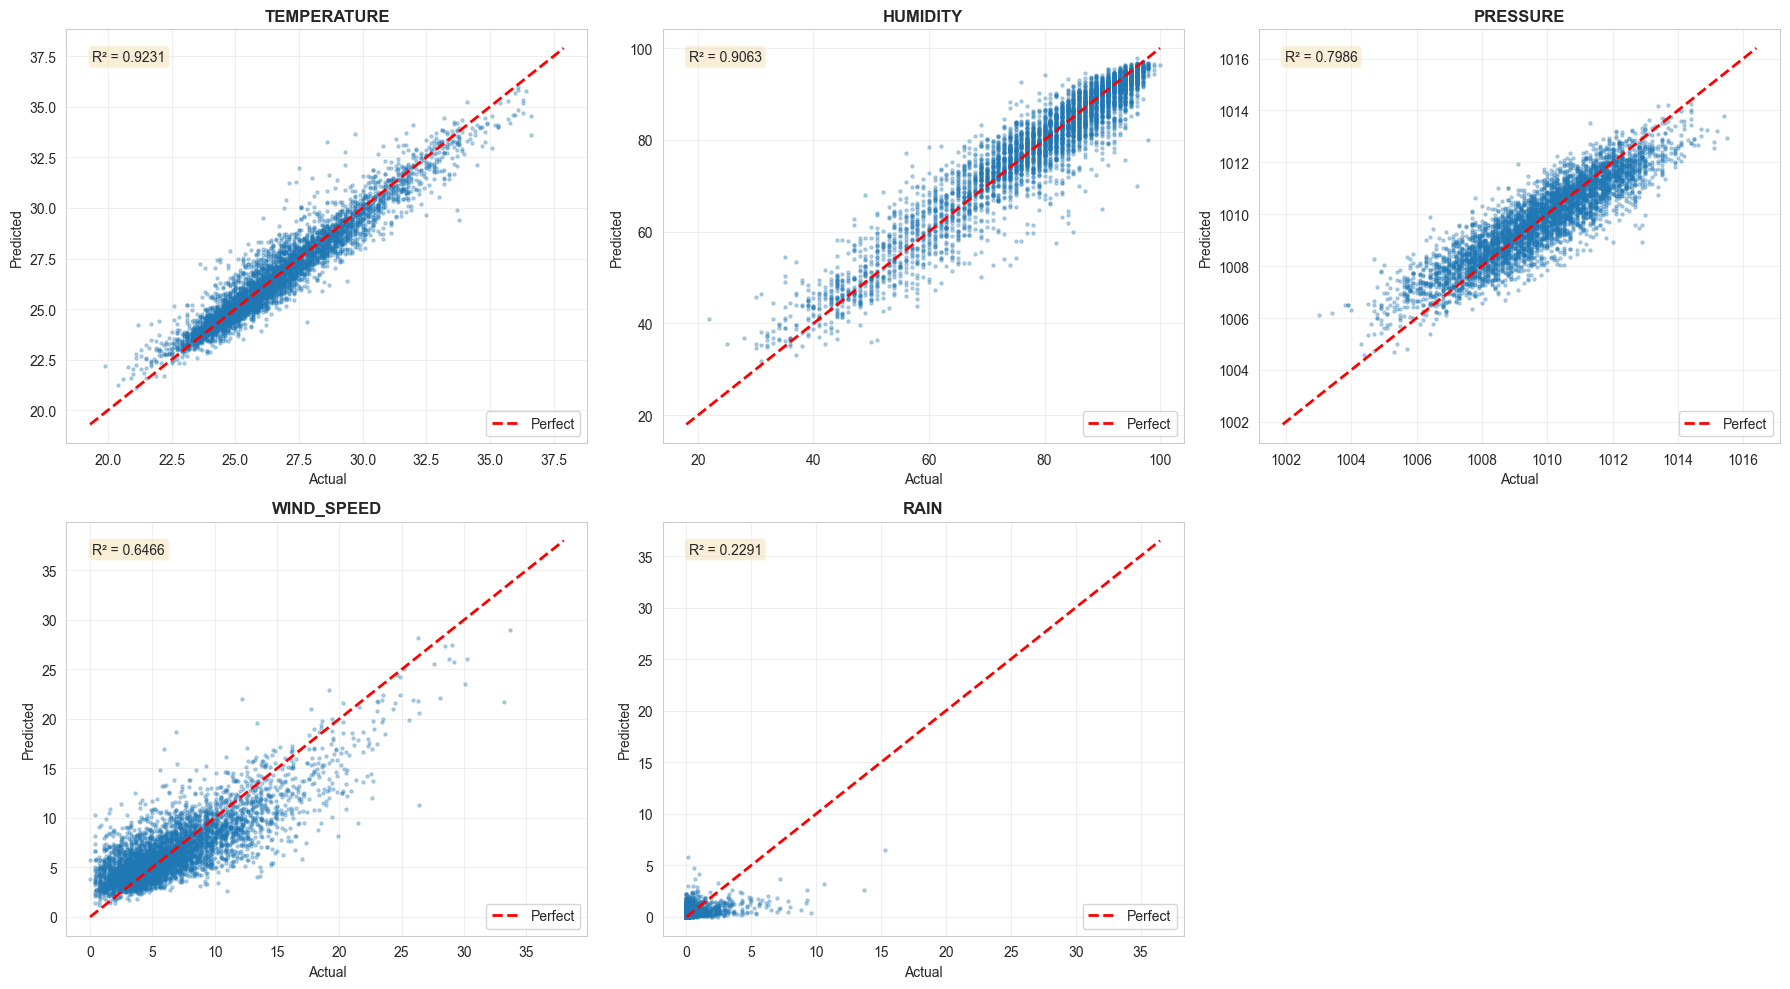

✓ Saved as '../outputs/hourly_actual_vs_predicted.png'


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, name in enumerate(target_names):
    ax = axes[i]
    
    # Sample for visualization (use 5000 points to avoid overcrowding)
    sample_size = min(5000, len(y_test))
    indices = np.random.choice(len(y_test), sample_size, replace=False)
    
    # Scatter plot
    ax.scatter(y_test.iloc[indices, i], y_pred[indices, i], alpha=0.3, s=5)
    
    # Perfect prediction line
    min_val = min(y_test.iloc[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test.iloc[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
    
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    ax.set_title(f'{name.upper()}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    ax.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('../outputs/hourly_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved as '../outputs/hourly_actual_vs_predicted.png'")

## 8. Feature Importance

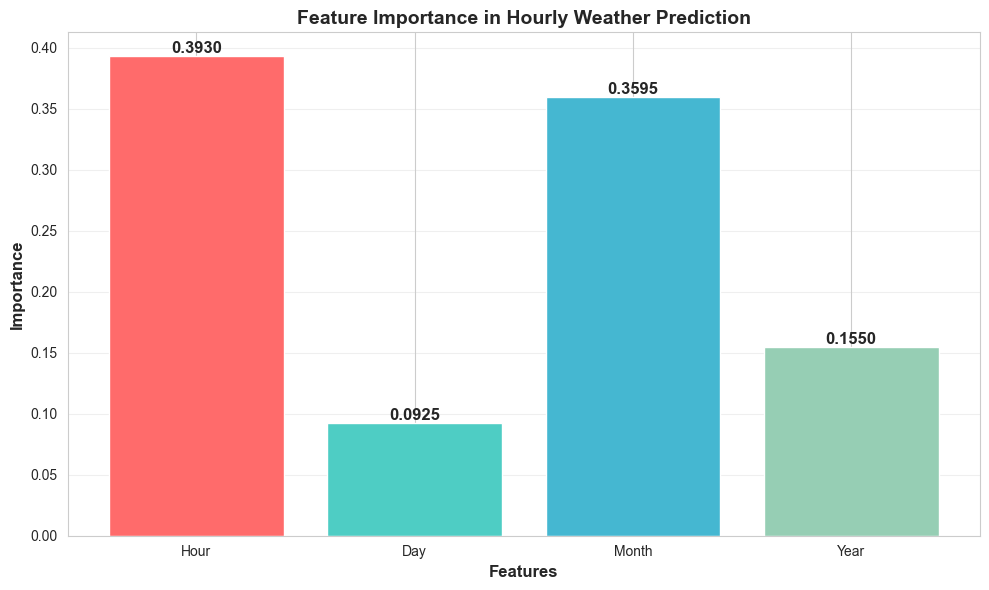

✓ Saved as '../outputs/hourly_feature_importance.png'


In [10]:
feature_names = ['Hour', 'Day', 'Month', 'Year']
importances = rf_model_hourly.feature_importances_

plt.figure(figsize=(10, 6))
bars = plt.bar(feature_names, importances, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Importance', fontsize=12, fontweight='bold')
plt.title('Feature Importance in Hourly Weather Prediction', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/hourly_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved as '../outputs/hourly_feature_importance.png'")

## 9. Time Series Comparison (Sample 7 Days)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


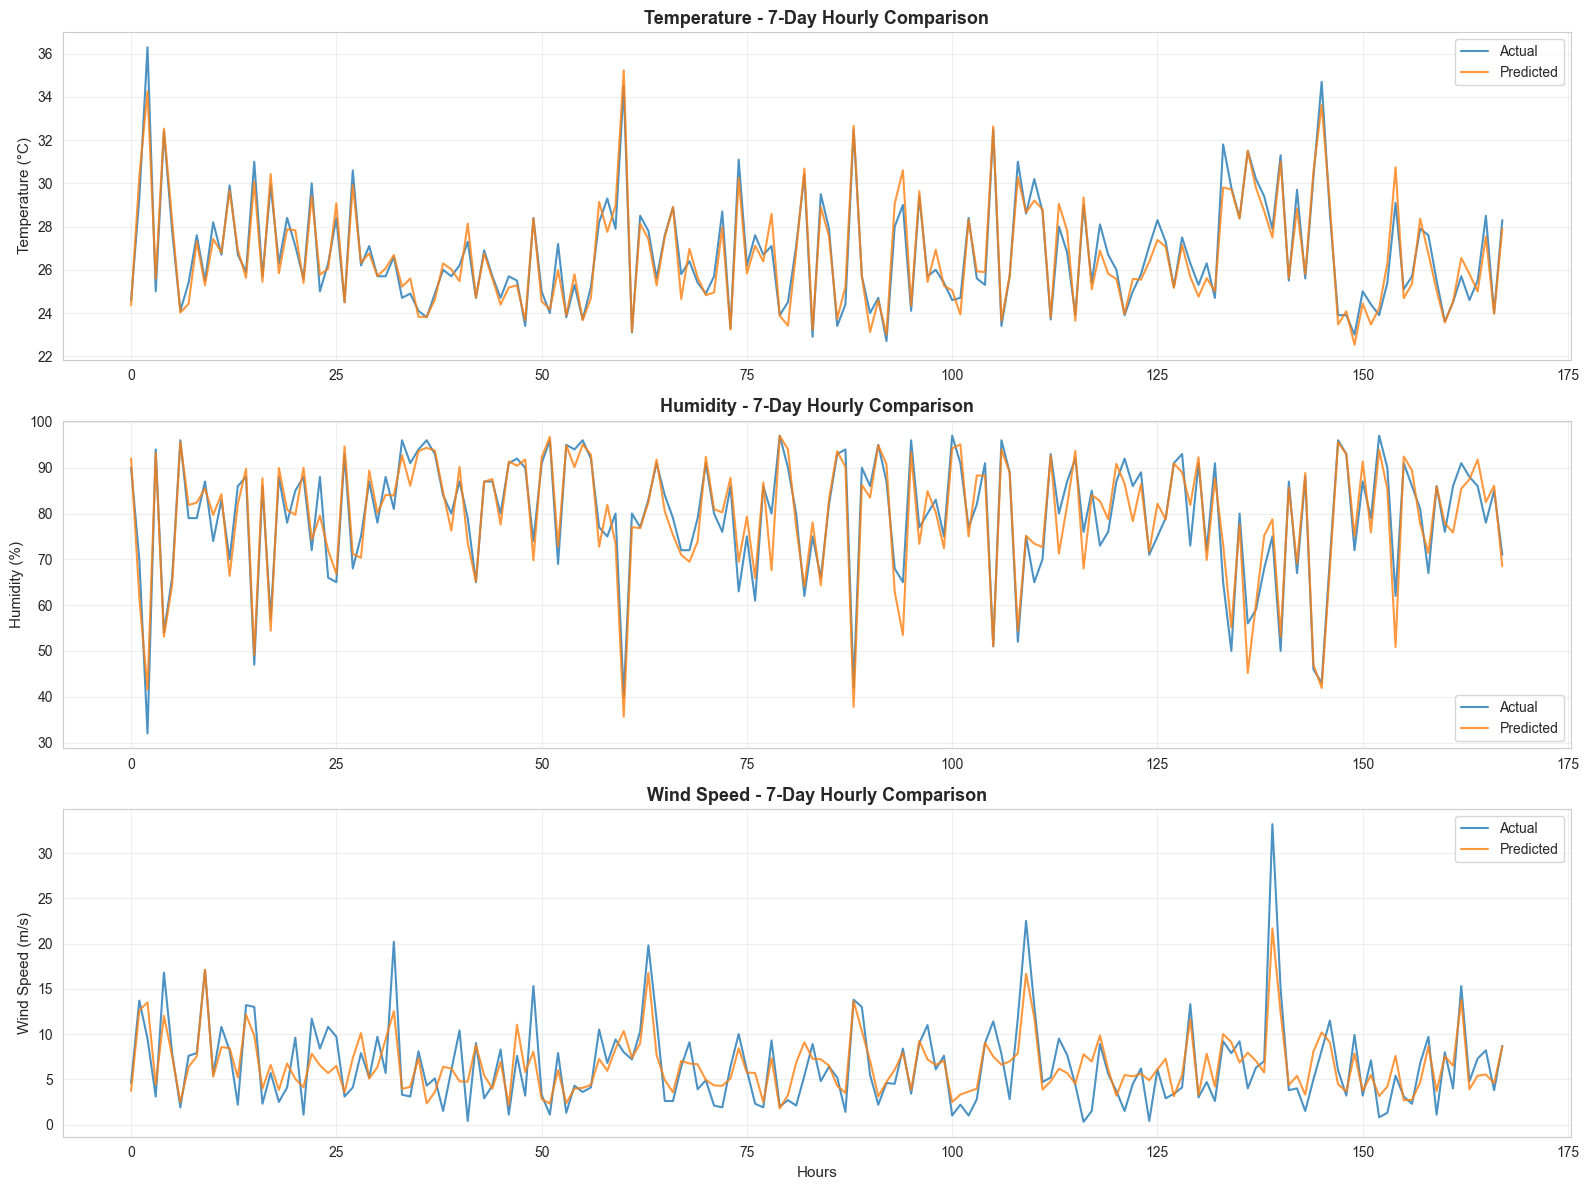

✓ Saved as '../outputs/hourly_timeseries_7days.png'


In [11]:
# Get 7 consecutive days from test set
sample_hours = 24 * 7  # 7 days
sample_size = min(sample_hours, len(X_test))

# Get sample
X_sample = X_test.iloc[:sample_size]
y_sample = y_test.iloc[:sample_size]
y_pred_sample = rf_model_hourly.predict(X_sample)

# Create time index for plotting
time_index = range(len(y_sample))

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Temperature
axes[0].plot(time_index, y_sample['temperature'], label='Actual', linewidth=1.5, alpha=0.8)
axes[0].plot(time_index, y_pred_sample[:, 0], label='Predicted', linewidth=1.5, alpha=0.8)
axes[0].set_ylabel('Temperature (°C)', fontsize=11)
axes[0].set_title('Temperature - 7-Day Hourly Comparison', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Humidity
axes[1].plot(time_index, y_sample['humidity'], label='Actual', linewidth=1.5, alpha=0.8)
axes[1].plot(time_index, y_pred_sample[:, 1], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1].set_ylabel('Humidity (%)', fontsize=11)
axes[1].set_title('Humidity - 7-Day Hourly Comparison', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Wind Speed
axes[2].plot(time_index, y_sample['wind_speed'], label='Actual', linewidth=1.5, alpha=0.8)
axes[2].plot(time_index, y_pred_sample[:, 3], label='Predicted', linewidth=1.5, alpha=0.8)
axes[2].set_xlabel('Hours', fontsize=11)
axes[2].set_ylabel('Wind Speed (m/s)', fontsize=11)
axes[2].set_title('Wind Speed - 7-Day Hourly Comparison', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/hourly_timeseries_7days.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved as '../outputs/hourly_timeseries_7days.png'")

## 10. Model Saving

In [13]:
# Retrain on full dataset for production
print("Retraining on full dataset for production...")
rf_model_final = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model_final.fit(X, y)

# Save model
with open('D://laragon//www//weather-iot//examples//model_training//models//rf_model_hourly_2000_2025_pkl', 'wb') as f:
    pickle.dump(rf_model_final, f)

print("\n" + "="*80)
print("✓ Model saved to 'D:/laragon/www/weather-iot/examples/model_training/models/rf_model_hourly_pkl'")
print("="*80)
print("Model Details:")
print(f"  Input features: {X.columns.tolist()}")
print(f"  Output targets: {y.columns.tolist()}")
print(f"  Training samples: {len(X):,} hours")
print(f"  Time span: ~{len(X)/24/365:.1f} years")
print("="*80)

Retraining on full dataset for production...

✓ Model saved to 'D:/laragon/www/weather-iot/examples/model_training/models/rf_model_hourly_pkl'
Model Details:
  Input features: ['hour', 'day', 'month', 'year']
  Output targets: ['temperature', 'humidity', 'pressure', 'wind_speed', 'rain']
  Training samples: 227,112 hours
  Time span: ~25.9 years


## 11. Verification

In [15]:
# Load model
with open('D://laragon//www//weather-iot//examples//model_training//models//rf_model_hourly_2000_2025_pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Test prediction (27 Nov 2025, 18:00)
test_input = pd.DataFrame([[18, 27, 11, 2025]], columns=['hour', 'day', 'month', 'year'])
prediction = loaded_model.predict(test_input)

print("="*80)
print("HOURLY MODEL VERIFICATION")
print("="*80)
print(f"Test Input: {test_input.iloc[0]['year']}-{test_input.iloc[0]['month']:02d}-{test_input.iloc[0]['day']:02d} "
      f"{test_input.iloc[0]['hour']:02d}:00")
print("\nPrediction:")
print("-" * 80)

target_names = ['temperature', 'humidity', 'pressure', 'wind_speed', 'rain']
for name, val in zip(target_names, prediction[0]):
    print(f"  {name.upper():<15}: {val:.4f}")

print("="*80)
print("✓ Model verification complete!")
print("="*80)

HOURLY MODEL VERIFICATION
Test Input: 2025-11-27 18:00

Prediction:
--------------------------------------------------------------------------------
  TEMPERATURE    : 27.4267
  HUMIDITY       : 81.6578
  PRESSURE       : 1008.0686
  WIND_SPEED     : 6.0060
  RAIN           : 0.0678
✓ Model verification complete!


## 12. 72-Hour Forecast (3 Days)

In [16]:
# Generate 72-hour forecast
start_datetime = datetime(2025, 11, 27, 18, 0)  # Start from 27 Nov 2025, 18:00
hours_to_predict = 72

print("="*100)
print("72-HOUR WEATHER FORECAST (3 DAYS)")
print("="*100)
print(f"Starting: {start_datetime.strftime('%A, %d %B %Y %H:%M')}\n")

hourly_forecast = []

for hour_offset in range(hours_to_predict):
    current_time = start_datetime + timedelta(hours=hour_offset)
    
    # Create input
    input_df = pd.DataFrame([[
        current_time.hour,
        current_time.day,
        current_time.month,
        current_time.year
    ]], columns=['hour', 'day', 'month', 'year'])
    
    # Predict
    pred = loaded_model.predict(input_df)[0]
    
    hourly_forecast.append({
        'datetime': current_time,
        'datetime_str': current_time.strftime('%Y-%m-%d %H:%M'),
        'temperature': pred[0],
        'humidity': pred[1],
        'pressure': pred[2],
        'wind_speed': pred[3],
        'rain': pred[4]
    })

# Convert to DataFrame
forecast_df = pd.DataFrame(hourly_forecast)

# Display first 24 hours (every 3 hours)
print("Sample: First 24 Hours")
print("=" * 100)
for i in range(0, min(24, len(forecast_df)), 3):
    row = forecast_df.iloc[i]
    rain_status = "🌧️ Rain" if row['rain'] > 0.5 else "☀️ No Rain"
    print(f"{row['datetime_str']} | Temp: {row['temperature']:.1f}°C | "
          f"Humidity: {row['humidity']:.1f}% | Wind: {row['wind_speed']:.1f} m/s | {rain_status}")

print("\n" + "="*100)
print(f"Total: {len(forecast_df)} hour predictions")
print("="*100)

72-HOUR WEATHER FORECAST (3 DAYS)
Starting: Thursday, 27 November 2025 18:00

Sample: First 24 Hours
2025-11-27 18:00 | Temp: 27.4°C | Humidity: 81.7% | Wind: 6.0 m/s | ☀️ No Rain
2025-11-27 21:00 | Temp: 27.1°C | Humidity: 81.8% | Wind: 5.2 m/s | ☀️ No Rain
2025-11-28 00:00 | Temp: 26.3°C | Humidity: 80.5% | Wind: 5.0 m/s | ☀️ No Rain
2025-11-28 03:00 | Temp: 26.1°C | Humidity: 82.0% | Wind: 4.9 m/s | ☀️ No Rain
2025-11-28 06:00 | Temp: 25.8°C | Humidity: 86.4% | Wind: 5.8 m/s | ☀️ No Rain
2025-11-28 09:00 | Temp: 31.2°C | Humidity: 58.9% | Wind: 4.5 m/s | ☀️ No Rain
2025-11-28 12:00 | Temp: 32.5°C | Humidity: 52.4% | Wind: 5.1 m/s | ☀️ No Rain
2025-11-28 15:00 | Temp: 31.7°C | Humidity: 56.0% | Wind: 6.8 m/s | ☀️ No Rain

Total: 72 hour predictions


### Visualize 72-Hour Forecast

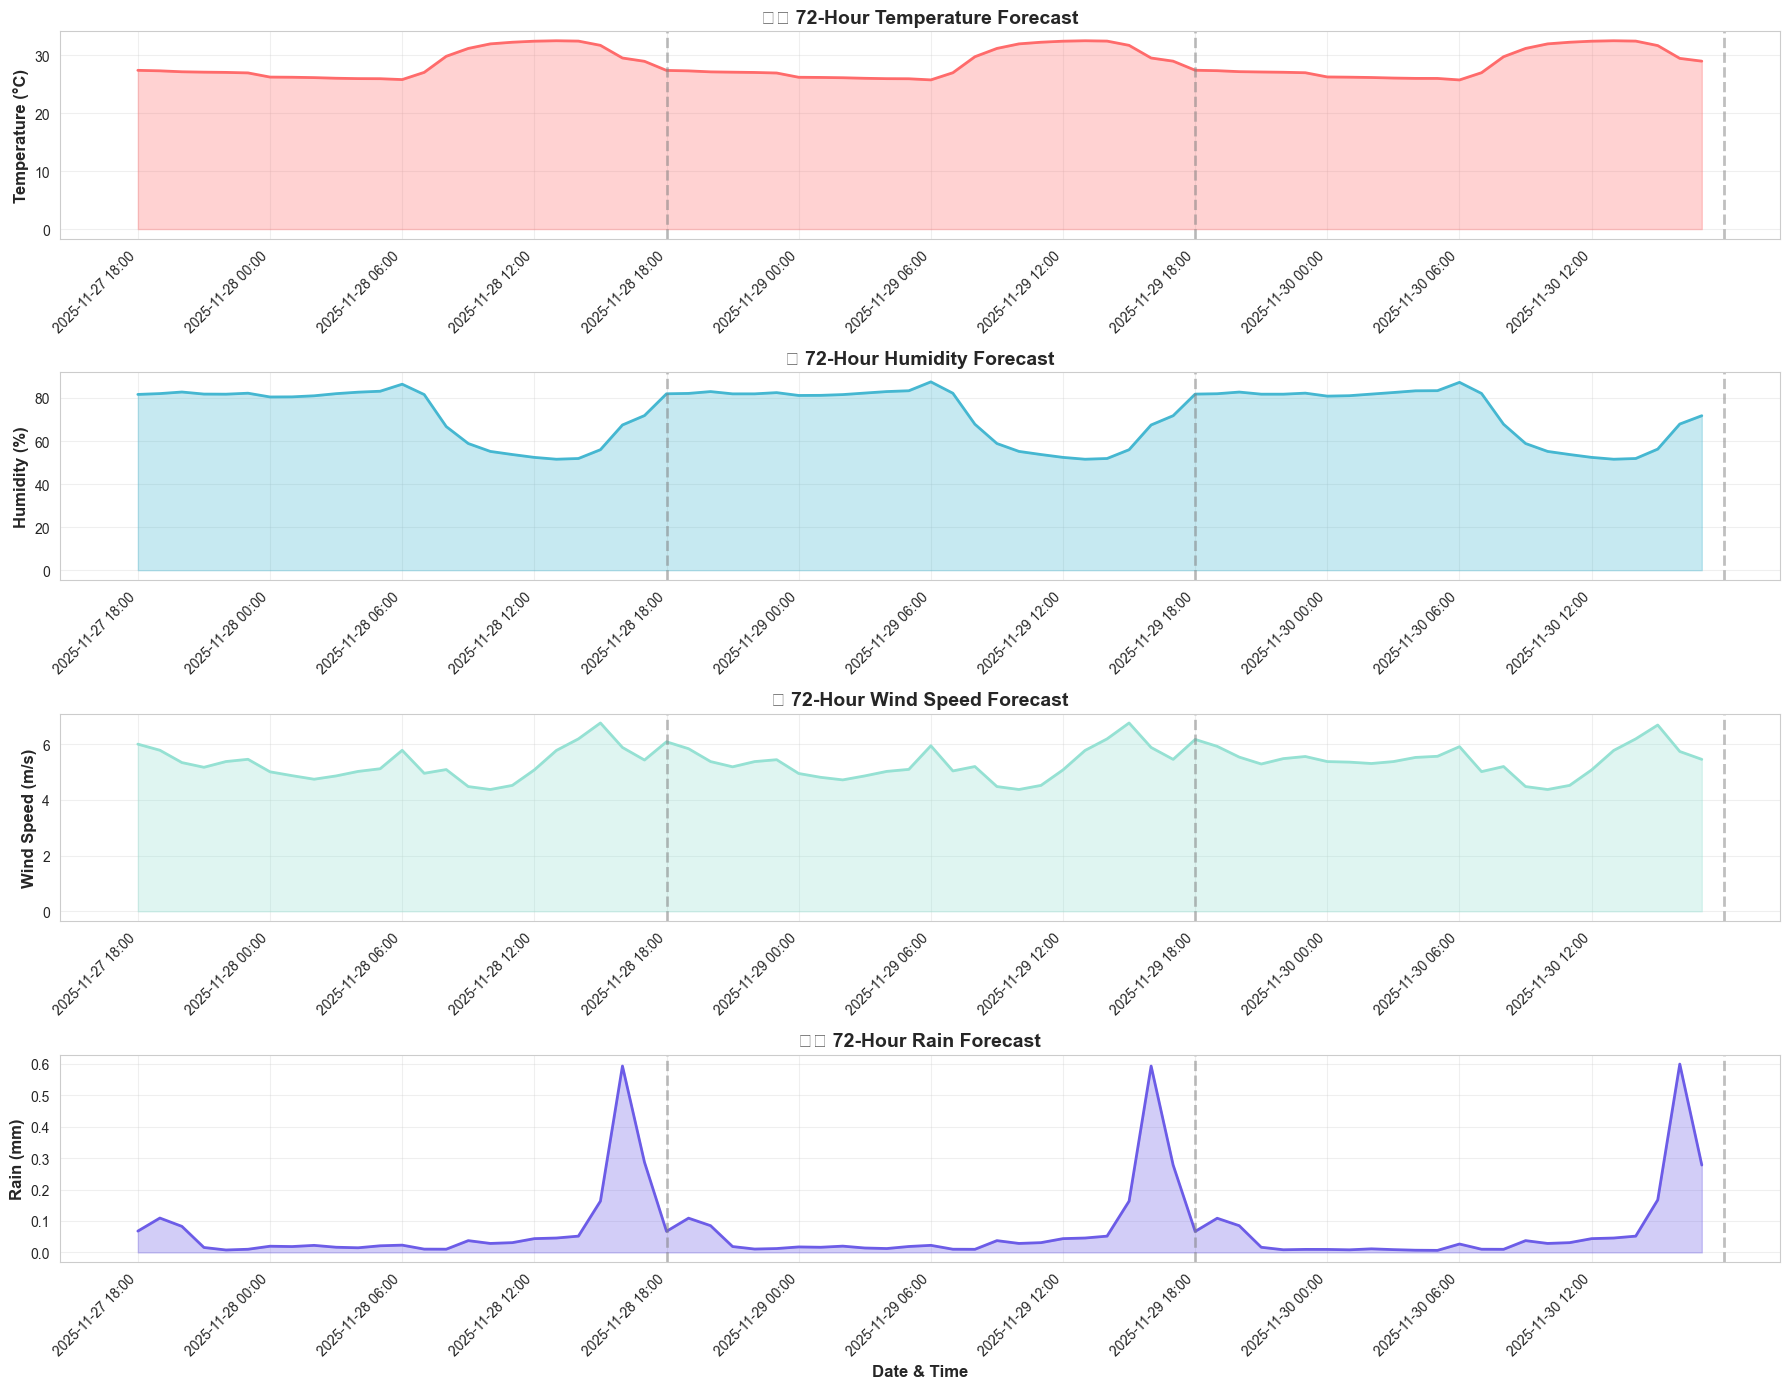

✓ Saved as '../outputs/hourly_72hour_forecast.png'

EXPORT OPTIONS:
CSV: forecast_df.to_csv('../outputs/hourly_forecast_72h.csv', index=False)
JSON: forecast_df.to_json('../outputs/hourly_forecast_72h.json', orient='records')


In [17]:
fig, axes = plt.subplots(4, 1, figsize=(18, 14))
hours = range(len(forecast_df))

# Temperature
axes[0].plot(hours, forecast_df['temperature'], linewidth=2, color='#FF6B6B')
axes[0].fill_between(hours, forecast_df['temperature'], alpha=0.3, color='#FF6B6B')
axes[0].set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
axes[0].set_title('🌡️ 72-Hour Temperature Forecast', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, len(forecast_df), 6))
axes[0].set_xticklabels([forecast_df.iloc[i]['datetime_str'] for i in range(0, len(forecast_df), 6)],
                        rotation=45, ha='right')

# Humidity
axes[1].plot(hours, forecast_df['humidity'], linewidth=2, color='#45B7D1')
axes[1].fill_between(hours, forecast_df['humidity'], alpha=0.3, color='#45B7D1')
axes[1].set_ylabel('Humidity (%)', fontsize=12, fontweight='bold')
axes[1].set_title('💧 72-Hour Humidity Forecast', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(0, len(forecast_df), 6))
axes[1].set_xticklabels([forecast_df.iloc[i]['datetime_str'] for i in range(0, len(forecast_df), 6)],
                        rotation=45, ha='right')

# Wind Speed
axes[2].plot(hours, forecast_df['wind_speed'], linewidth=2, color='#95E1D3')
axes[2].fill_between(hours, forecast_df['wind_speed'], alpha=0.3, color='#95E1D3')
axes[2].set_ylabel('Wind Speed (m/s)', fontsize=12, fontweight='bold')
axes[2].set_title('💨 72-Hour Wind Speed Forecast', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(range(0, len(forecast_df), 6))
axes[2].set_xticklabels([forecast_df.iloc[i]['datetime_str'] for i in range(0, len(forecast_df), 6)],
                        rotation=45, ha='right')

# Rain
axes[3].plot(hours, forecast_df['rain'], linewidth=2, color='#6C5CE7')
axes[3].fill_between(hours, forecast_df['rain'], alpha=0.3, color='#6C5CE7')
axes[3].set_ylabel('Rain (mm)', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Date & Time', fontsize=12, fontweight='bold')
axes[3].set_title('🌧️ 72-Hour Rain Forecast', fontsize=14, fontweight='bold')
axes[3].grid(True, alpha=0.3)
axes[3].set_xticks(range(0, len(forecast_df), 6))
axes[3].set_xticklabels([forecast_df.iloc[i]['datetime_str'] for i in range(0, len(forecast_df), 6)],
                        rotation=45, ha='right')

# Add day separators
for ax in axes:
    for day in range(1, 4):
        ax.axvline(x=day*24, color='gray', linestyle='--', alpha=0.5, linewidth=2)

plt.tight_layout()
plt.savefig('../outputs/hourly_72hour_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved as '../outputs/hourly_72hour_forecast.png'")
print("\n" + "="*100)
print("EXPORT OPTIONS:")
print("="*100)
print("CSV: forecast_df.to_csv('../outputs/hourly_forecast_72h.csv', index=False)")
print("JSON: forecast_df.to_json('../outputs/hourly_forecast_72h.json', orient='records')")
print("="*100)